
# Hito 2 y 3: Propuesta metodológica experimental inicial, experimentación y análisis de resultados

**Noviembre 2023**

**Universidad de Chile**

___
**Profesores:** Cinthia Sánchez Macías y Jazmine Maldonado.
___
**Auxiliares:** Fran Antonie Zautzik Rojas y María José Zambrano Burrows.
___
**Curso:** Minería de Datos CC5205.
___
**Grupo 11:** David Felipe, Cristian Jara, Alfredo Padilla, Gonzalo Serradilla y Pablo Vergara.

## Importar los datos y librerías
Se puede cambiar el *dirección* de los datos. Los datos que se importaron son que se obtuvieron luego de limpiar los datos en el hito 1.

In [2]:
# Url de los datos
url = "https://raw.githubusercontent.com/davidnfu0/data-mining-en-incendios-de-Chile/main/data/data_incendios_limpio.csv"

In [3]:
import pandas as pd # Importar librería pandas
import numpy as np # Importar librería numpy
df = pd.read_csv(url) # Cargar el dataset

In [4]:
df.head()

,Region,Provincia,Comuna,Temporada,Nombre,Fecha,HoraInicio,DuracionMinutos,Alerta,Escenario,...,SuperficieQuemadaArbolado,SuperficieQuemadaMatorral,SuperficieQuemadaPastizal,SuperficieQuemadaAgricola,SuperficieQuemadaDesechos,SuperficieQuemadaTotal,Latitud,Longitud,Datum,SuperficieQuemadaPino
0,Coquimbo,Elqui,La Serena,2002-2003,ALTOVALSOL,2002-07-05,21:05,195.0,Sin alerta,No definido,...,0.0,0.01,0.03,0.0,0.0,0.04,-29.935556,-71.108333,WGS84,0.0
1,Coquimbo,Elqui,La Serena,2002-2003,CERES,2002-10-25,11:50,137.0,Sin alerta,No definido,...,0.0,0.01,0.01,0.0,0.0,0.02,-29.933611,-71.211944,WGS84,0.0
2,Coquimbo,Limarí,Punitaqui,2002-2003,LA RINCONADA,2002-10-27,11:50,190.0,Sin alerta,No definido,...,0.0,0.00,0.01,0.0,0.0,0.01,-30.833056,-71.368056,WGS84,0.0
3,Coquimbo,Elqui,Coquimbo,2002-2003,CERRO LA VIRGEN.,2002-11-02,17:00,90.0,Sin alerta,No definido,...,0.0,0.50,1.50,0.0,0.0,2.00,-29.995833,-71.275556,WGS84,0.0
4,Coquimbo,Elqui,La Serena,2002-2003,LA VARILLA,2002-11-02,15:30,210.0,Sin alerta,No definido,...,0.0,2.00,5.00,0.0,0.0,7.00,-29.880000,-71.190000,WGS84,0.0


In [5]:
df['Datum'].unique()

array(['WGS84'], dtype=object)

Se puede notar que la columna *Datum* posee el mismo valor para todos los datos, por lo que no aporta información relevante. Por lo tanto, esta columna no se utilizará de aquí en adelante.

In [6]:
df.drop(columns = 'Datum', inplace = True)

## Preguntas de investigación planteadas en el Hito 1

___
1. ¿Es factible predecir la severidad de un incendio forestal en curso y determinar el nivel de alerta correspondiente basándose en sus características y factores actuales?
___
2. ¿Se pueden usar los registros existentes de incendios para identificar patrones y características predictivas que diferencien entre causas intencionales y no intencionales?
___
3. ¿Se pueden identificar grupos de incendios que compartan características similares, y estos grupos podrían proporcionarnos información valiosa para abordar eficazmente estas situaciones de emergencia?

## Propuesta experimental

A continuación se desarrollará la propuesta experimental que busca dar respuesta a nuestras preguntas.

---

**General para todas la preguntas:**

- Para comenzar, se creará una nueva columna llamada 'Intencional' que tendrá el valor '1' si el incendio es de carácter intencional y '0' si no lo es, en el caso de que la causa no esté definida o sea desconocida el valor de esta columna será 'None'. Además se creará una nueva columna llamada 'Mes' que tendrá el mes en que ocurrió el incendio, pues, es el único dato referente a la fecha que consideramos importante para el estudio, es importante mencionar que este dato se va a almacenar como una variable numérica.
  
- La columna 'Alerta' para el análisis, esta se convertirá en un formato numérico: asignaremos un '0' a los registros de incendios que no posean alerta, '1' para alertas de nivel amarillo, y '2' para las de nivel rojo. Asimismo, modificaremos la columna 'Hora inicio' para reflejar el tiempo transcurrido en minutos desde la medianoche hasta el momento en que se declaró cada incendio, considerando únicamente las horas y minutos. Este ajuste permite una mejor integración de los datos en los modelos predictivos. También se va a modificar la columna escenario, pasandola a datos de tipo númerico para facilitar el uso de modelos.

- Para reducir la cantidad de registros que se van a utilizar, se va a considerar solo los incendios que consideramos más relevantes. El criterio de selección a utilizar es solo considerar los incendios con una superficie total quemada mayor a $0.2[ha]$, que hayan durado más de $15[min]$.

**Pregunta 1:**

  - Con el objetivo de responder esta pregunta, dado el carácter predictivo de esta pregunta se realizarán técnicas de clasificación multiclase sobre la columna *Alerta*, la cual posee tres rangos que determinan la severidad de un incendio: *Sin Alerta*, *Alerta Amarilla* y *Alerta Roja*. Para ello, se considerará un conjunto de *15* variables: *Mes*, *Hora inicio*, *Duración Minutos*, *Escenario*, *Región*, *Superficie quemada Pino*, *Superficie quemada Eucalipto*, *Superficie quemada Otras plantas*, *Superficie quemada Arbolado*, *Superficie quemada Matorral*, *Superficie quemada Pastizal*, *Superficie quemada Agrícola*, *Superficie quemada Desechos*, *Superficie quemada total*, *Latitud* y *Longitud*.
  
  - Es importante notar que no se van a utilizar las columnas 'Causa' e 'Intencional' debido a que se considera que al momento de utilizar el modelo no se conocen con precisión y no parecen ser importantes para la predicción. Por otro lado, se dejan lado las variables 'Comuna' y 'Provincia', ya que, se asume que estos datos ya estan representados en las variables 'Región', 'Latitud' y 'Longitud', esto último también aplica para el metodología experimental para la pregunta **2**.

  - Ahora, se puede ver que la mayor parte de los registros están clasificados como *Sin Alerta*.


In [7]:
print(pd.value_counts(df['Alerta'], sort = True))

Alerta
Sin alerta         108911
Alerta roja           726
Alerta amarilla       348
Name: count, dtype: int64


C:\Users\David\AppData\Local\Temp\ipykernel_11056\1916609674.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df['Alerta'], sort = True))


- Se emplearán diversos algoritmos de clasificación, entre ellos *Árboles de Decisión*, *SVM* y *Naive Bayes*. Además, para evaluar el desempeño de cada algoritmo se usarán las métricas *Accuracy*, *Precision*, *Recall* y *F1-score*. En cuanto a los conjuntos de entrenamiento y testeo, se propone una partición de $70\%$ para entrenar el modelo y un $30\%$ para testearlo. Para solucionar el desbalanceo de clases, se aplicará *SubSampling* a la clase mayoritaria. De esta forma, el modelo de clasificación no se verá afectado por la dominancia de los registros *Sin Alerta*.

- Luego de hacer y evaluar los modelos se va a seleccionar el modelo con mejores métricas para optimizar sus hiperparámetros. Para ello se va a utilizar *GridSearch*. Luego, se va a evaluar el modelo con los mejores hiperparámetros con los datos de prueba.

**Pregunta 2:**

- Para responder esta pregunta es importante notar que en el *data frame* existe el atributo *causa*, el cual indica la causa del incendio. Una de las causas es *incendios intencionales*, por lo que se puede usar este atributo para clasificar los incendios en intencionales y no intencionales.

- Dado que la pregunta es de carácter predictivo, nos enfocaremos de manera particular en un modelo de clasificación binaria. Donde se busca predecir la intencionalidad de un incendio en base a sus características. Es decir, buscamos predecir valores de la columna *Intencional*.
  
- Se va a utilizar un conjunto de $16$ características para predecir la intencionalidad de un incendio. Estas son: *Mes*, *Hora inicio*, *Duración Minutos*, *Alerta*, *Escenario*, *Región*, *Superficie quemada Pino*, *Superficie quemada Eucalipto*, *Superficie quemada Otras plantas*, *Superficie quemada Arbolado*, *Superficie quemada Matorral*, *Superficie quemada Pastizal*, *Superficie quemada Agrícola*, *Superficie quemada Desechos*, *Superficie quemada total*, *Latitud* y *Longitud*.
  
- Para la evaluar la calidad de la clasificación se van a utilizar diversos algoritmos y compraremos sus métricas. Los algoritmos a utilizar son: *Árbol de decisión*, *SVM* y *Naive Bayes*. Las métricas a utilizar son: *Accuracy*, *Precision*, *Recall* y *F1-score*. La partición que utilizaremos es de $70\%$ para entrenamiento y $30\%$ para prueba. Además se va a hacer un *SubSampling* de los datos de entrenamiento, pues, la cantidad de incendios intencionales es menor en comparación con los no intencionales. Por lo tanto, se va a disminuir la cantidad de incendios intencionales en el conjunto de entrenamiento.

- Luego de hacer y evaluar los modelos se va a seleccionar el modelo con mejores métricas para optimizar sus hiperparámetros. Para ello se va a utilizar *GridSearch*. Luego, se va a evaluar el modelo con los mejores hiperparámetros con los datos de prueba.

**Pregunta 3:**

- Para poder responder esta pregunta se utilizarán técnicas de *Clustering* que nos permitan reconocer grupos que se forman de manera intrínseca en los datos. Para esto se utilizarán los algoritmos *K-means*, *DBSCAN* y *Gaussian Mixture Models*.

- Se van a utilizar un conjunto de características para generar los *Clusters* y luego, evaluarlos. Las características que se van a utilizar son características numéricas, ya sean continuas o discretas.
  
- Las características que se van a utilizar se van a normalizar, pues, se asume que las características tienen distintas escalas y se quiere que todas tengan el mismo peso al momento de generar los *Clusters*. La normalización está dada por: $x_{norm} = \frac{x - \mu}{\sigma}$, donde $\mu$ es el estimador de momentos de la esperanza y $\sigma$ es el estimador de momentos insesgado de la desviación estándar de la característica $x$

- Para evaluar los *Clusters* se va a usar el enfoque visual creando la matriz de proximidad, para esto se va a aplicar *PCA* para reducir la dimensionalidad de los datos, a solo dos componentes. Además, se van a gráficar los *Clusters* en un plano cartesiano para poder hacer un análisis cualitativo.
  
- También se va a utilizar métricas numéricas para evaluar la calidad de los *Clusters*. Las métricas a utilizar son: *Silhouette Score*, *Cohesión* y *Separación*.
  
- Por otro lado, para elegir una óptima cantidad de *Clusters* se va a utilizar el método del codo (en el caso de *K-means* y *Gaussian Mixture Models*) y el método de la rodilla (en el caso de *DBSCAN*). 
  
- Es importante mencionar que los clusters generados, también, se van a evaluar de manera cualitativa.
  
- Por último, se interpretarán los *Clusters* obtenidos y se analizarán las características de los incendios que pertenecen a cada *Cluster*. Para así obtener información relevante y entender que representan.

## Experimentos 

En esta sección se realizaran los experimentos para responder las preguntas de investigación planteadas en el hito 1.

### Preliminares

#### Librerías
---

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score, normalized_mutual_info_score, f1_score, recall_score, precision_score, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import warnings

#### Función para eliminar warnings
___

In [9]:
# Función para eliminar los warnings

def no_show_warnings() -> None:
    warnings.filterwarnings("ignore")
    warnings.warn("DelftStack")
    warnings.warn("Do not show this message")

#### Creación y modificación de variables del Data Frame
___
Aquí se crean y mofican las variables del Data Frame para su posterior uso en los modelos de clasificación, siguiendo lo comentado en la propuesta metodologíca.

In [10]:
# Crear la columna Intencional según cómo fueron etiquetados en la variable Causa
conditions = [
    df['Causa'] == 'Incendios intencionales',
    df['Causa'].isin(['No definida', 'Incendios de causa desconocida'])
]

choices = [1, 'None']

df['Intencional'] = np.select(conditions, choices, default=0)

# Crear la variable Mes a partir de la variable Fecha
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m-%d')
df['Mes'] = df['Fecha'].dt.month

# Convertir Regiones a valores numéricos
df = df.replace({'Region': {'Coquimbo': 4, 'Valparaíso': 5, "O'Higgins": 6, 'Maule': 7, 'Biobío': 8,
       'Araucanía': 9, 'Los Lagos': 10, 'Magallanes': 12, 'Metropolitana': 13,
       'Los Ríos': 14, 'Aysén': 11, 'Atacama': 3, 'Arica y Parinacota': 15, 'Tarapacá': 1,
       'Antofagasta': 2, 'Ñuble': 16}})

# Convertir Alerta a valores numéricos
df = df.replace({'Alerta': {'Sin alerta': 0, 'Alerta roja': 2, 'Alerta amarilla': 1}})

# Convertir Hora inicio a valores numéricos
df["HoraInicio"] = pd.to_datetime(df["HoraInicio"], format="%H:%M").dt.hour * 60 + pd.to_datetime(df["HoraInicio"], format="%H:%M").dt.minute

# Convertir Escenario a valores numéricos
df = df.replace({'Escenario': {'No definido': 0, 'IFor-Vn': 1, 'IFIUr-Fo': 2, 'IFor-PI': 3, 'IFASP': 4, 'IFIns': 5,
       'IFCo': 6, 'IFSu': 7, 'IFCSo': 8}})

In [11]:
df.tail(10) # Mostrar el dataset luego de las modificaciones

,Region,Provincia,Comuna,Temporada,Nombre,Fecha,HoraInicio,DuracionMinutos,Alerta,Escenario,...,SuperficieQuemadaMatorral,SuperficieQuemadaPastizal,SuperficieQuemadaAgricola,SuperficieQuemadaDesechos,SuperficieQuemadaTotal,Latitud,Longitud,SuperficieQuemadaPino,Intencional,Mes
109975,14,Valdivia,Mariquina,2019-2020,PURINGUE POBRE II,2020-04-07,780,81.0,0,1,...,0.0,0.20,0.0,0.0,0.20,-39.471667,-73.001667,0.0,0,4
109976,14,Valdivia,Mariquina,2019-2020,RUCACO,2020-04-11,930,29.0,0,3,...,0.0,0.00,0.0,1.0,1.75,-39.585000,-72.899722,0.0,0,4
109977,15,Arica,Camarones,2019-2020,GUATANAVE,2019-07-04,930,1192.0,0,0,...,0.3,0.19,0.0,0.0,0.50,-18.823611,-69.723611,0.0,0,7
109978,15,Arica,Arica,2019-2020,LA PONDEROSA I,2019-08-10,797,379.0,0,0,...,0.6,2.00,0.0,0.0,2.60,-18.420556,-70.317778,0.0,1,8
109979,15,Arica,Arica,2019-2020,LA PONDEROSA II,2019-08-12,571,194.0,0,0,...,0.0,0.60,0.0,0.0,0.60,-18.418056,-70.315556,0.0,1,8
109980,15,Arica,Arica,2019-2020,LA PONDEROSA III,2019-08-13,939,48.0,0,0,...,0.0,0.01,0.0,0.0,0.01,-18.416944,-70.315556,0.0,1,8
109981,15,Parinacota,Putre,2019-2020,CAMINO VIEJO PUTRE,2019-09-18,1167,123.0,0,0,...,0.0,0.50,0.0,0.0,0.60,-18.187778,-69.542222,0.0,None,9
109982,15,Arica,Arica,2019-2020,KM 20 LLUTA,2019-12-08,855,192.0,0,0,...,0.0,0.02,0.0,0.0,0.02,-18.416944,-70.111111,0.0,0,12
109983,15,Parinacota,Putre,2019-2020,RESERVA NACIONAL LAS VICUÑAS,2019-12-10,900,1248.0,0,0,...,0.0,0.50,0.0,0.0,0.50,-18.855278,-69.162222,0.0,0,12
109984,15,Arica,Camarones,2019-2020,CAMARONES 1,2020-05-15,616,314.0,0,0,...,0.0,18.00,0.0,0.0,18.00,-19.004167,-69.853333,0.0,0,5


#### Selección de datos
___
En este inciso se van a seleccionar los datos de incendios que consideramos más relevantes. El criterio de selección a utilizar es solo considerar los incendios con una superficie total quemada mayor a $0.2[ha]$ y que hayan durado más de $15[min]$. Además, que tengan la intencionalidad definida.

In [12]:
filtro_superficie = df['SuperficieQuemadaTotal'] >= 0.2 # Crear el filtro de superficie quemada
filtro_tiempo = df['DuracionMinutos'] >= 15 # Crear el filtro de duración del incendio
filtro_intencionalidad = df['Intencional'] != 'None' # Crear el filtro de intencionalidad
df_mod = df[filtro_superficie & filtro_tiempo & filtro_intencionalidad] # Aplicar los filtros para obtener el nuevo dataset
df_mod.shape # Mostrar dimensiones del nuevo dataset

(57486, 24)

In [13]:
# Mostrar las columnas del nuevo dataset
i = 0
for col in df_mod.columns:
    print(i, ": ",col)
    i += 1

0 :  Region
1 :  Provincia
2 :  Comuna
3 :  Temporada
4 :  Nombre
5 :  Fecha
6 :  HoraInicio
7 :  DuracionMinutos
8 :  Alerta
9 :  Escenario
10 :  Causa
11 :  SuperficieQuemadaEucalipto
12 :  SuperficieQuemadaOtrasPlantas
13 :  SuperficieQuemadaArbolado
14 :  SuperficieQuemadaMatorral
15 :  SuperficieQuemadaPastizal
16 :  SuperficieQuemadaAgricola
17 :  SuperficieQuemadaDesechos
18 :  SuperficieQuemadaTotal
19 :  Latitud
20 :  Longitud
21 :  SuperficieQuemadaPino
22 :  Intencional
23 :  Mes


### Experimento 2
(Pregunta 2)

#### Selección de las columnas que se van a utilizar para predecir y la que se va a predecir:
___

In [14]:
X = df_mod.iloc[:,[6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,23]].to_numpy() # Seleccionar las columnas a utilizar para predecir
y = df_mod.iloc[:, 22].to_numpy() # Seleccionar la columna a predecir

#### Creación y evaluación de los modelos
___
Ahora se van a crear y evaluar los modelos planteados en la metodología experimental.

In [15]:
def run_classifier(clf, X, y, num_tests=1, subsample_class=True, num_splits=5) -> dict:
    metrics = {'f1-score': [], 'precision': [], 'recall': [], 'y_pred': [], 'accuracy': [], 'clasification_report': [], 'confusion_matrix': []}

    lista_random_state = [14*i for i in range(num_tests)]

    for i in range(num_tests):
        if subsample_class: # Si subsample_class = True, se hace el subsampling de la clase 1
            idx_class_1 = np.where(y == 1)[0]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=lista_random_state[i])# Se crean los conjuntos de entrenamiento y test
            rus = RandomUnderSampler(sampling_strategy='auto', random_state=lista_random_state[i])
            X_train, y_train = rus.fit_resample(X_train, y_train) # Se genera el subsampling sobre el conjunto de entrenamiento
        else: # Si subsample_class = False, no se hace subsamplig
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=lista_random_state[i], stratify=y) #Se crean los conjuntos de entrenamiento y test

        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        # Se guardan las métricas del conjunto
        metrics['y_pred'].append(predictions)
        metrics['f1-score'].append(f1_score(y_test, predictions, average='weighted'))
        metrics['recall'].append(recall_score(y_test, predictions, average='weighted'))
        metrics['precision'].append(precision_score(y_test, predictions, average='weighted'))
        metrics['accuracy'].append(accuracy_score(y_test, predictions))
        metrics['clasification_report'].append(classification_report(y_test, predictions))

    return metrics

In [16]:
# Se definen los modelos a entrenar
c1 = ("Decision Tree", DecisionTreeClassifier(max_depth=5))
c2 = ("Gaussian Naive Bayes", GaussianNB())
c3 = ("Support Vector Machines", SVC())

classifiers = [c1, c2, c3]

results = {}
for name, clf in classifiers:
    print("----------------")
    print("Resultados para clasificador: ", name)
    metrics = run_classifier(clf, X, y, num_tests=2)  # Se corre los modelos, segun el número de test
    results[name] = metrics
    print("Acurracy promedio:", np.array(metrics['accuracy']).mean())   # Se imprime el promedio de las métricas
    print("Precision promedio:", np.array(metrics['precision']).mean())
    print("Recall promedio:", np.array(metrics['recall']).mean())
    print("F1-score promedio:", np.array(metrics['f1-score']).mean())
    n_model = 0
    for clr in metrics['clasification_report']:
        print("----------------")
        print('Clasification Report Model: ', n_model + 1)
        print(clr)
        n_model += 1
    print("----------------\n\n")

----------------
Resultados para clasificador:  Decision Tree
Acurracy promedio: 0.7244868375275426
Precision promedio: 0.7406396265021573
Recall promedio: 0.7244868375275426
F1-score promedio: 0.7302361200542891
----------------
Clasification Report Model:  1
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     11953
           1       0.54      0.64      0.59      5293

    accuracy                           0.73     17246
   macro avg       0.69      0.70      0.69     17246
weighted avg       0.74      0.73      0.73     17246

----------------
Clasification Report Model:  2
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     11924
           1       0.54      0.65      0.59      5322

    accuracy                           0.72     17246
   macro avg       0.69      0.70      0.69     17246
weighted avg       0.74      0.72      0.73     17246

----------------


----------------
R

#### Elección de Hiperparámetros
---


Luego de correr los modelos, "Decision Tree" obtuvo los mejores resultados en cada una de las métricas, es por esto que se usará la libreria OpenSerachCV, para con el fin de poder encontrar los mejores hiperáparmetros que se ajusten al modelo.

In [17]:
# Definición del modelo
dtc = DecisionTreeClassifier()
# Se crea el conjunto de train y test
idx_class_1 = np.where(y == 1)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)# Se crean los conjuntos de train y test
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)# Se hace subsampling sobre el conjunto de entrenamiento


# Definición de los hiperparámetros a buscar

param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 8]
}

# Búsqueda de los hiperparámetros según
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}


Ahora con los mejores hiperparámetros encontrados se entrena el modelo y se evalua.

              precision    recall  f1-score   support

           0       0.85      0.71      0.77     11867
           1       0.53      0.72      0.61      5379

    accuracy                           0.71     17246
   macro avg       0.69      0.71      0.69     17246
weighted avg       0.75      0.71      0.72     17246



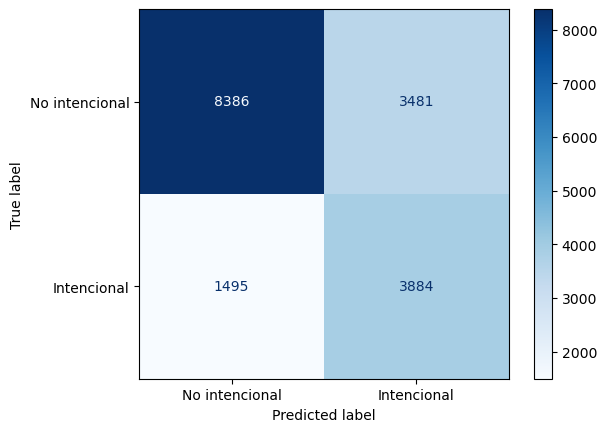

In [18]:
dtc = DecisionTreeClassifier(max_depth=10, min_samples_leaf= 4, min_samples_split= 2) # Se define el modelo
dtc.fit(X_resampled, y_resampled) # Se entrena el modelo
predictions = dtc.predict(X_test)
cm = confusion_matrix(y_test, predictions)# Se genera y muestra la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No intencional', 'Intencional'])
disp.plot(cmap=plt.cm.Blues, ax=None, xticks_rotation='horizontal')
print(classification_report(y_test, predictions))

#### Conclusión del experimento
---
Una vez realizado el experimento sí se pueden identificar ciertos patrones para diferenciar las causas entre intencionales y no intencionales, la precisión de la clase no intencional es relativamente alta (0,85), por lo que las instancias clasificadas como no intencionales, el 85% realmente lo son, pero la precisión en la clase intencional es mucho más baja, ya que es solo alcanza un (0.53), por lo que el 52% de las instancias que son intencionales, realmente lo son.

En conclusión, aunque el modelo tiene un rendimiento aceptable en la identificación de estos patrones, la capacidad del modelo para poder predecir incendios intenciones tiene un gran margen de mejora. El modelo se podría ajustar de mejor manera si se complementara con datos meteorológicos, opinión de expertos, para saber que parámetros tienen mayor relevancia que otros, y con una mejor elección de los hiperparámetros o algoritmos a utilizar.


### Experimento 3

#### Preliminares
___
En está sección se van a seleccionar las columnas que se van a utilizar para generar los *Clusters* y se van a normalizar los datos.

Es importante mencionar que no se va a utilizar la columna *Intencional* para generar los *Clusters*, pues, hay muchos incendios que no tienen definida su intencionalidad.

In [19]:
df_clustering = df_mod.iloc[:,[6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,23]]

In [20]:
df_clustering.dtypes

HoraInicio                         int32
DuracionMinutos                  float64
Alerta                             int64
Escenario                          int64
SuperficieQuemadaEucalipto       float64
SuperficieQuemadaOtrasPlantas    float64
SuperficieQuemadaArbolado        float64
SuperficieQuemadaMatorral        float64
SuperficieQuemadaPastizal        float64
SuperficieQuemadaAgricola        float64
SuperficieQuemadaDesechos        float64
SuperficieQuemadaTotal           float64
Latitud                          float64
Longitud                         float64
SuperficieQuemadaPino            float64
Mes                                int32
dtype: object

Se puede notar que todos los datos que se van a utilizar son de tipo numérico.

Ahora se van a normalizar los datos:

In [21]:
no_show_warnings()

# Estandarizar los datos
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_clustering) 

In [22]:
no_show_warnings()

# Normalizar los datos 
df_clustering = normalize(scaled_df)

# Convertir a un DataFrame
df_clustering = pd.DataFrame(df_clustering)

In [23]:
df_clustering.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.134389,0.502329,-0.056660,-0.217816,-0.018050,-0.008765,-0.012333,-0.019697,-0.014189,-0.008269,-0.025915,-0.019796,0.560361,0.176653,-0.011571,0.575613
1,-0.064365,-0.340217,-0.055979,-0.215200,-0.017834,-0.008660,-0.016979,-0.023974,-0.026749,-0.008170,-0.025604,-0.023907,0.583571,0.180482,-0.011432,0.673899
2,0.223277,-0.348112,-0.054243,-0.208526,-0.017281,-0.008391,-0.016452,-0.022793,-0.026605,-0.007917,-0.024810,-0.023166,0.575641,0.146848,-0.011077,0.652999
3,0.208204,-0.371073,-0.058002,-0.222975,-0.018478,-0.008973,-0.017592,-0.024840,-0.025517,-0.008465,-0.026529,-0.024415,0.505085,0.140361,-0.011845,0.698248
4,-0.068454,-0.375990,-0.054827,-0.210771,-0.017467,-0.008481,-0.016629,-0.023480,-0.026199,-0.008002,-0.025077,-0.023415,0.574584,0.193573,-0.011196,0.660031


Ya están normalizados los datos, por lo que se pueden utilizar para generar los *Clusters*.

#### K-Means
___

En esta sección se va a generar los *Clusters* utilizando el algoritmo *K-Means*.

Para comenzar se va a utilizar el método del codo para elegir la cantidad de *Clusters* óptima.

In [24]:
def metodo_codo(num_clusters:list, 
                xline_1:int, 
                xline_2:int, 
                xline_3:int, 
                df=df_clustering, 
                figsize_tuple=(10,8)) -> None:
    """Genera el gráfico para utilizar el método del codo"""
    inercias = []
    for i in num_clusters:
        modelo = KMeans(n_clusters=i, random_state=42)
        modelo.fit(df)
        inercias.append(modelo.inertia_)
    plt.figure(figsize=figsize_tuple)
    plt.plot(num_clusters, inercias, '-o')
    plt.axvline(x=xline_1, color='red', linestyle='--')
    plt.axvline(x=xline_2, color='green', linestyle='--')
    plt.axvline(x=xline_3, color='orange', linestyle='--')
    plt.title('Método del codo')
    plt.xlabel('N Clusters')
    plt.xticks(num_clusters)
    plt.show()

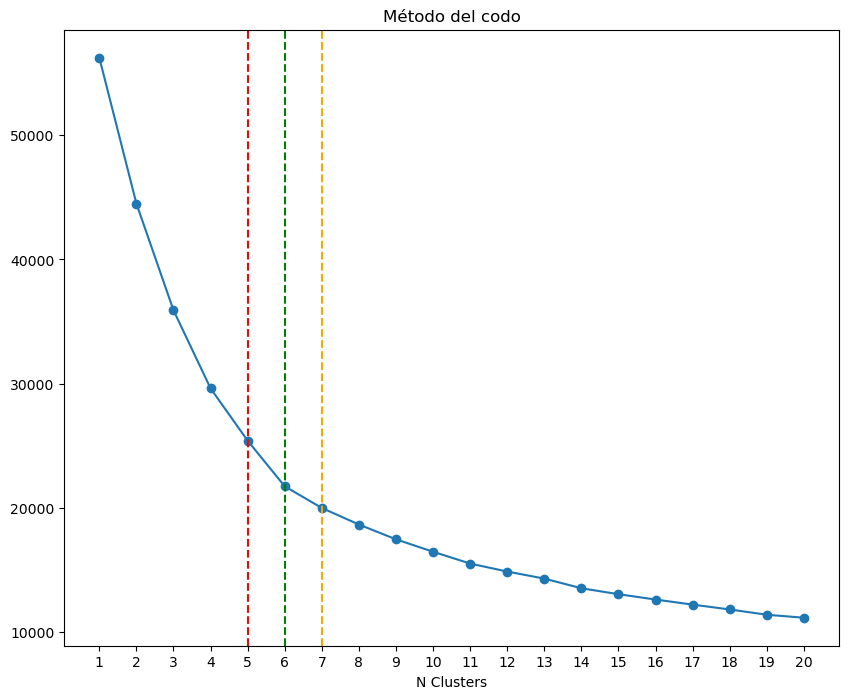

In [25]:
metodo_codo(num_clusters=range(1,21),
            xline_1=5,
            xline_2=6,
            xline_3=7)

Se puede notar que el codo se produce entre $5$, $6$ y $7$ *Clusters*, por lo que se va a probar con todas esas cantidades de *Clusters*.

Ahora se van a generar los *Clusters* con $5$, $6$ y $7$ *Clusters*.

In [26]:
# Crear los modelos de K-Means
kmeans_5 = KMeans(n_clusters=5, n_init=10, max_iter=100, random_state=42)
kmeans_5.fit(df_clustering)

kmeans_6 = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=42)
kmeans_6.fit(df_clustering)

kmeans_7 = KMeans(n_clusters=4, n_init=10, max_iter=100, random_state=42)
kmeans_7.fit(df_clustering)

KMeans(max_iter=100, n_clusters=4, random_state=42)

#### DBSCAN
___

En esta sección se va a generar los *Clusters* utilizando el algoritmo *DBSCAN*.

Para comenzar se va a utilizar el método de la rodilla para elegir el valor de $\epsilon$ óptimo.

In [27]:
def metodo_rodilla(N:int,
                   yline:float,
                   df=df_clustering, 
                   figsize_tuple=(10,8)) -> None:
    """Genera el gráfico para utilizar el método de la rodilla"""
    nbrs = NearestNeighbors(n_neighbors=N).fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,N-1]
    plt.figure(figsize=figsize_tuple)
    plt.plot(distances)
    plt.axhline(y=yline, color='r', linestyle='--')
    plt.xlabel('Puntos del dataset ordenados')
    plt.ylabel('k-ésima distancia al vecino más cercano')
    plt.show()

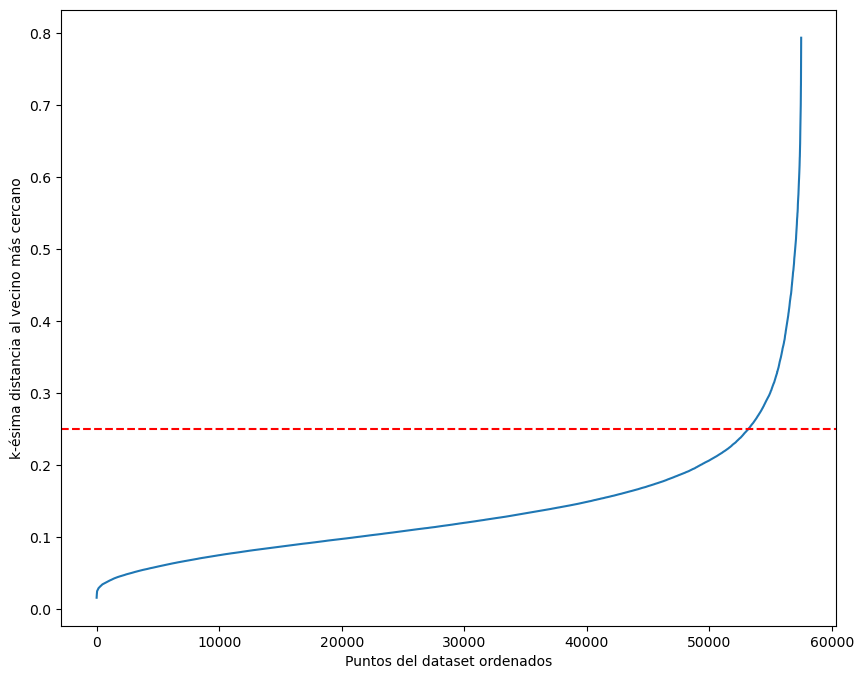

In [28]:
no_show_warnings()
metodo_rodilla(N=10, yline=0.25)

Se puede notar que el codo se produce aproximandamente en $0.25$ para $N=10$, por lo que se va a hacer *DBSCAN* con ese valor de $\epsilon$.

A continuación se va a generar los *Clusters* con $N=10$ y $\epsilon=0.25$:

In [29]:
# Crear modelo de DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=10)
dbscan.fit(df_clustering)

DBSCAN(eps=0.25, min_samples=10)

#### Gaussian Mixture Models
___

En esta sección se va a generar los *Clusters* utilizando el algoritmo *Gaussian Mixture Models*.

Se va a utilizar la misma cantidad de componentes que *Clusters* que se obtuvieron con el método del codo para *K-Means*. Por lo que se van a generar $5$, $6$ y $7$ *Clusters*.

In [31]:
# Crear GMM
gmm_5 = GaussianMixture(n_components=5, random_state=42) 
gmm_5.fit(df_clustering)

gmm_6 = GaussianMixture(n_components=6, random_state=42) 
gmm_6.fit(df_clustering)

gmm_7 = GaussianMixture(n_components=7, random_state=42) 
gmm_7.fit(df_clustering)

GaussianMixture(n_components=7, random_state=42)

#### Evaluación de los Clusters
___

En esta sección se va a evaluar los *Clusters* generados con los algoritmos *K-Means*, *DBSCAN* y *Gaussian Mixture Models*.

## Aportes específicos de cada miembro Hito 2
___

Todos los integrantes participaron de las siguientes secciones:

Reformulación de preguntas de investigación y Conclusión del experimento.

- **David Felipe:** Experimento Preliminar, Creación y evaluación de los modelos

- **Cristian Jara:** Experimento Preliminar, Elección de hiperpárametros

- **Alfredo Padilla:** Propuesta experimental, Creación y evaluación de los modelos

- **Gonzalo Serradilla:** Presentación, Creación y evaluación de los modelos

- **Pablo Vergara:** Propuesta experimental, Elección de hiperpárametros

___